## Data preparation & cleaning

In [1]:
# Environment setup
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

Let's import the data take a brief view first.

In [2]:
df_train_raw = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test_raw = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

df0 = df_train_raw.copy() #df0 is for cleaning and EDA only
df0.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Let's change column names to lower case, replace long name, and drop `id` column.

In [3]:
df0.columns = df0.columns.str.lower()
df0.rename(columns={'family_history_with_overweight':'history'}, inplace=True)
df0.drop(columns=['id'], inplace=True)
df0.head()

,gender,age,height,weight,history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gender      20758 non-null  object 
 1   age         20758 non-null  float64
 2   height      20758 non-null  float64
 3   weight      20758 non-null  float64
 4   history     20758 non-null  object 
 5   favc        20758 non-null  object 
 6   fcvc        20758 non-null  float64
 7   ncp         20758 non-null  float64
 8   caec        20758 non-null  object 
 9   smoke       20758 non-null  object 
 10  ch2o        20758 non-null  float64
 11  scc         20758 non-null  object 
 12  faf         20758 non-null  float64
 13  tue         20758 non-null  float64
 14  calc        20758 non-null  object 
 15  mtrans      20758 non-null  object 
 16  nobeyesdad  20758 non-null  object 
dtypes: float64(8), object(9)
memory usage: 2.7+ MB


There are 17 columns and 20,758 rows, no missing value.  
Now let's make sense of all the rows. Google search yields below info:

| **Column** | **Description**                                                                                                                                                      |
|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| FAVC       | Frequency of consuming high-calorie foods and contains two levels, where Yes and No mean high-frequency and low-frequency intake of high caloric foods respectively. |
| FCVC       | Frequency of vegetable intake in meals, where FCVC > 2 means positive vegetable intake in every meal and FCVC ≤ 2 means zero vegetable intake for some meals.        |
| NCP        | Number of main meals in a day.                                                                                                                                       |
| CAEC       | Frequency of sub-meals between main meals.                                                                                                                           |
| CH2O       | Amount of daily water intake in liters.                                                                                                                              |
| SCC        | Binary indicator of food calorie monitoring and comprises two levels: Yes and No.                                                                                    |
| FAF        | Frequency of physical activity.                                                                                                                                      |
| TUE        | Time spent on technological devices.                                                                                                                                 |
| CALC       | Alcohol intake levels.                                  |
| MTRANS     | The usual means of transportation and consists of five levels: Automobile, Motorbike, Bike, Public Transportation and Walking                                        |
| NObeyesdad | Obesity level.                                                                                                                                                       |

The string type columns should be either boolean or categorical. Let's transform them.

In [5]:
for col in df0.columns:
    if df0[col].dtype == 'object':
        print(col, set(df0[col]))

gender {'Female', 'Male'}
history {'no', 'yes'}
favc {'no', 'yes'}
caec {'no', 'Frequently', 'Sometimes', 'Always'}
smoke {'no', 'yes'}
scc {'no', 'yes'}
calc {'no', 'Frequently', 'Sometimes'}
mtrans {'Automobile', 'Bike', 'Public_Transportation', 'Walking', 'Motorbike'}
nobeyesdad {'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II', 'Obesity_Type_I', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_III'}


In [6]:
# tranform boolean columns
for col in ['history', 'favc', 'smoke', 'scc']:
    df0[col] = df0[col].map({'yes': True, 'no': False})

# transfer categorical columns
df0['gender'] = pd.Categorical(df0['gender'], 
                               categories=['Male', 'Female'],
                               ordered=True)
df0['caec'] = pd.Categorical(df0['caec'],
                             categories=['no', 'Sometimes', 'Frequently', 'Always'],
                             ordered=True)
df0['calc'] = pd.Categorical(df0['calc'],
                             categories=['no', 'Sometimes', 'Frequently'],
                             ordered=True)
df0['mtrans'] = pd.Categorical(df0['mtrans'],
                               categories=['Walking', 'Public_Transportation', 'Bike', 
                                           'Motorbike', 'Automobile'],
                               ordered=True)
df0['nobeyesdad'] = pd.Categorical(df0['nobeyesdad'],
                                   categories=['Insufficient_Weight', 'Normal_Weight', 
                                               'Overweight_Level_I', 'Overweight_Level_II', 
                                               'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 
                                   ordered=True)

# show result
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gender      20758 non-null  category
 1   age         20758 non-null  float64 
 2   height      20758 non-null  float64 
 3   weight      20758 non-null  float64 
 4   history     20758 non-null  bool    
 5   favc        20758 non-null  bool    
 6   fcvc        20758 non-null  float64 
 7   ncp         20758 non-null  float64 
 8   caec        20758 non-null  category
 9   smoke       20758 non-null  bool    
 10  ch2o        20758 non-null  float64 
 11  scc         20758 non-null  bool    
 12  faf         20758 non-null  float64 
 13  tue         20758 non-null  float64 
 14  calc        20758 non-null  category
 15  mtrans      20758 non-null  category
 16  nobeyesdad  20758 non-null  category
dtypes: bool(4), category(5), float64(8)
memory usage: 1.4 MB


In [7]:
df0.duplicated().sum()

0

There is no duplicate entry.

In [8]:
df0.describe(include='all')

,gender,age,height,weight,history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
count,20758,20758.000000,20758.000000,20758.000000,20758,20758,20758.000000,20758.000000,20758,20758,20758.000000,20758,20758.000000,20758.000000,20758,20758,20758
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,Female,NaN,NaN,NaN,True,True,NaN,NaN,Sometimes,False,NaN,False,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,NaN,NaN,NaN,17014,18982,NaN,NaN,17529,20513,NaN,20071,NaN,NaN,15066,16687,4046
mean,NaN,23.841804,1.700245,87.887768,NaN,NaN,2.445908,2.761332,NaN,NaN,2.029418,NaN,0.981747,0.616756,NaN,NaN,NaN
std,NaN,5.688072,0.087312,26.379443,NaN,NaN,0.533218,0.705375,NaN,NaN,0.608467,NaN,0.838302,0.602113,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,20.000000,1.631856,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.792022,NaN,0.008013,0.000000,NaN,NaN,NaN
50%,NaN,22.815416,1.700000,84.064875,NaN,NaN,2.393837,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.573887,NaN,NaN,NaN
75%,NaN,26.000000,1.762887,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.549617,NaN,1.587406,1.000000,NaN,NaN,NaN


Overall there seems no abnormal data.

According to the description of FCVC, it is better to transform this column to boolean type also.

In [9]:
df0['fcvc'] = df0['fcvc'].round(2) > 2
df0['fcvc'].dtype

dtype('bool')

## EDA and feature engineer

Let's make a new column `bmi` and drop `height`, `weight`.

In [10]:
df0['bmi'] = df0['weight'] / np.square(df0['height'])
df0.drop(columns=['height', 'weight'], inplace=True)

df0.columns

Index(['gender', 'age', 'history', 'favc', 'fcvc', 'ncp', 'caec', 'smoke',
       'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'bmi'],
      dtype='object')

For each categorical column, let's make a new column to store the encode number for numerical analysis.

In [11]:
for col in df0.columns:
    if df0[col].dtype == 'category':
        df0[col+'_lvl'] = df0[col].cat.codes

df0.columns

Index(['gender', 'age', 'history', 'favc', 'fcvc', 'ncp', 'caec', 'smoke',
       'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'bmi',
       'gender_lvl', 'caec_lvl', 'calc_lvl', 'mtrans_lvl', 'nobeyesdad_lvl'],
      dtype='object')

Let's check data balance (for categorical features) and distribution (for numerical features).

In [12]:
for col in df0.columns[:16]:
    if df0[col].dtype in ['category', 'bool']:
        print(df0[col].value_counts(normalize=True))
        print()

gender
Female    0.502071
Male      0.497929
Name: proportion, dtype: float64

history
True     0.819636
False    0.180364
Name: proportion, dtype: float64

favc
True     0.914443
False    0.085557
Name: proportion, dtype: float64

fcvc
True     0.561326
False    0.438674
Name: proportion, dtype: float64

caec
Sometimes     0.844446
Frequently    0.119087
Always        0.023027
no            0.013441
Name: proportion, dtype: float64

smoke
False    0.988197
True     0.011803
Name: proportion, dtype: float64

scc
False    0.966904
True     0.033096
Name: proportion, dtype: float64

calc
Sometimes     0.725792
no            0.248723
Frequently    0.025484
Name: proportion, dtype: float64

mtrans
Public_Transportation    0.803883
Automobile               0.170248
Walking                  0.022497
Motorbike                0.001831
Bike                     0.001542
Name: proportion, dtype: float64

nobeyesdad
Obesity_Type_III       0.194913
Obesity_Type_II        0.156470
Normal_Weight     

Some features (favc, smoke, scc) show very high data imbalance. We need to take special care to split train and validate datasets.

Some features (caec, calc, mtrans) show very low representative for some categories. Luckily these features all should be encoded by order, so maybe not much affecting the model performance.

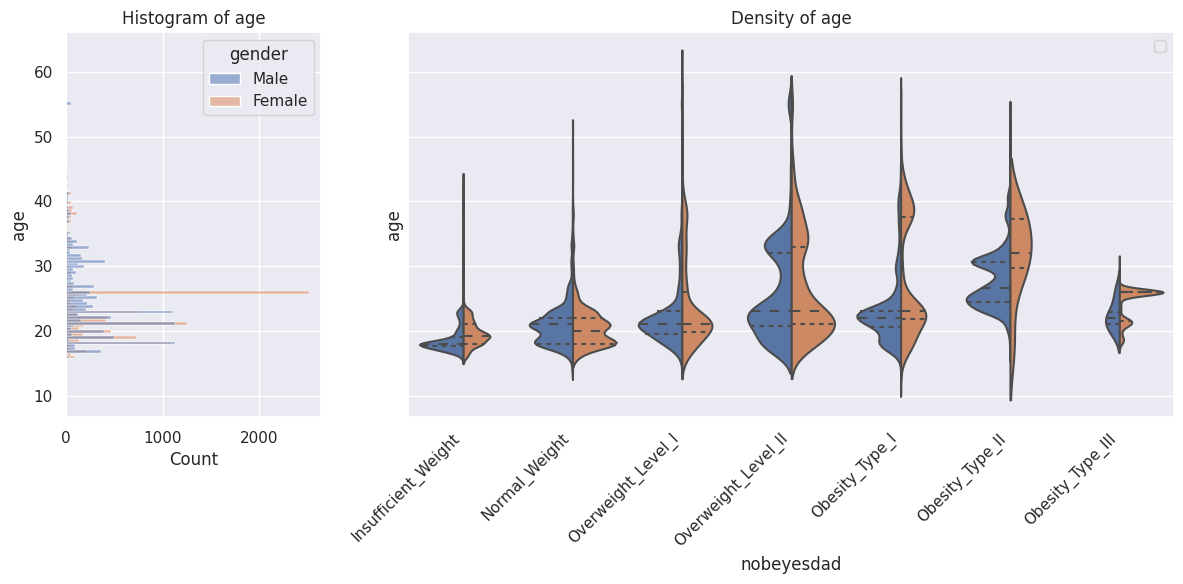

In [13]:
col = 'age'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- Young (<30) people obesity levels are widely distributed.  
- Mid age and higher are mostly overweight level II to obesity type II levels.
- `Obesity_Type_III` distribution is very different from other obesity types.
- Male and female show bigger difference with higher obesity types.

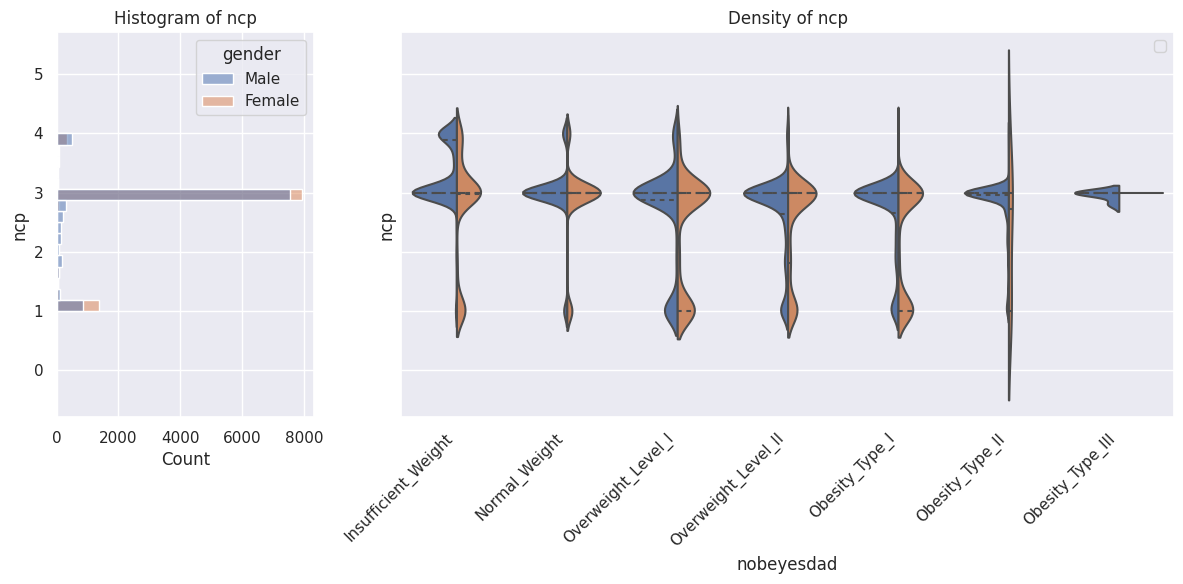

In [14]:
col = 'ncp'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- People eat only 1 meal per day has less extreme obesity issue, likely due to they are on diet.
- People eat 4 meals per day has little obesity issue. Maybe they pay more attention on healthy diet.
- Males tends to eat more meals per day than females.

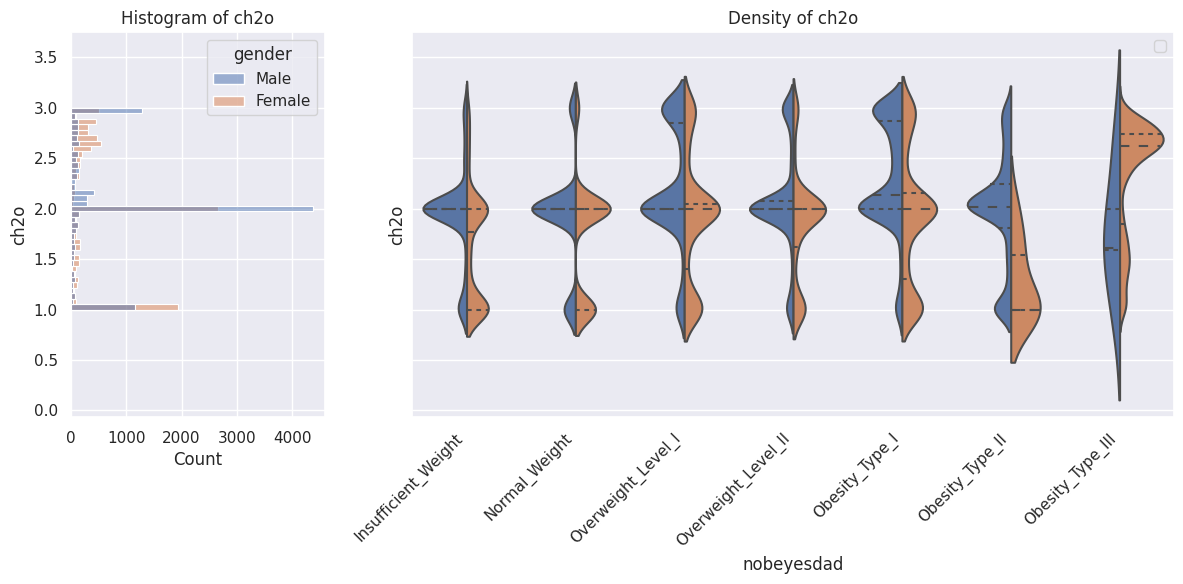

In [15]:
col = 'ch2o'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

`Obesity_Type_III` and `Obesity_Type_II` distributions show very big gender bias.

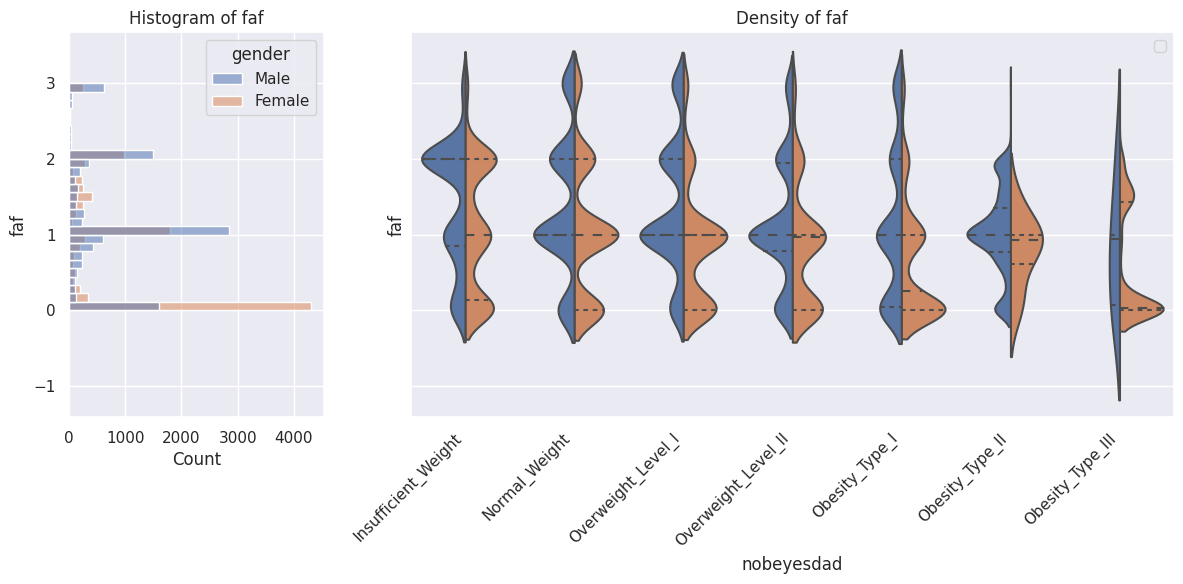

In [16]:
col = 'faf'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

`Obesity_Type_III` risk is high for people who don't have physical activity, which is expected. However, why is there a peak ~1.5 for females? Maybe they start to exercise for health concern?

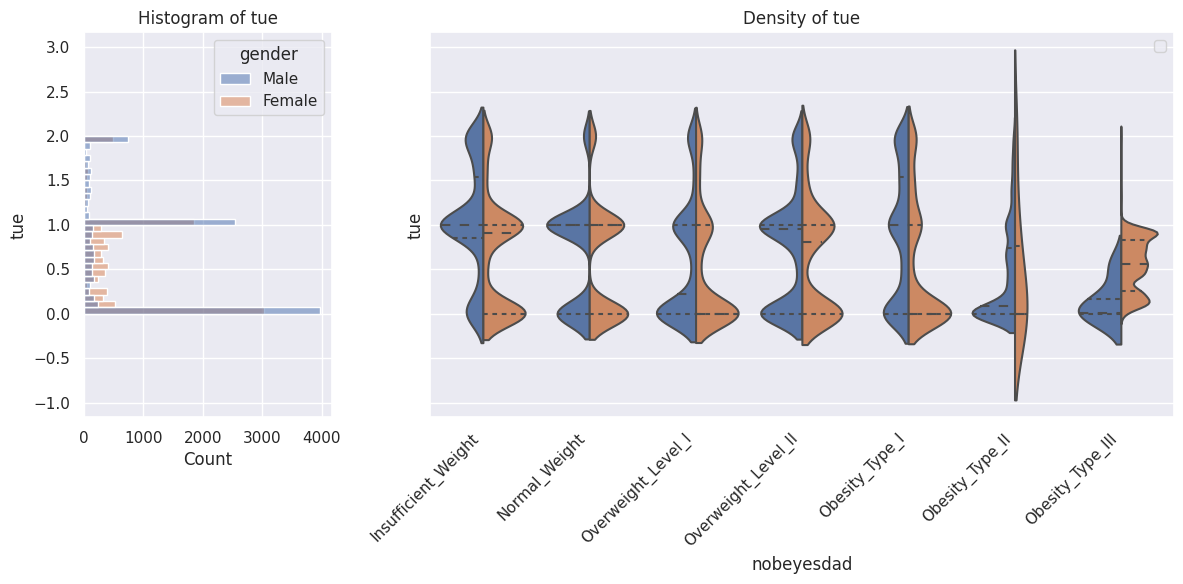

In [17]:
col = 'tue'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

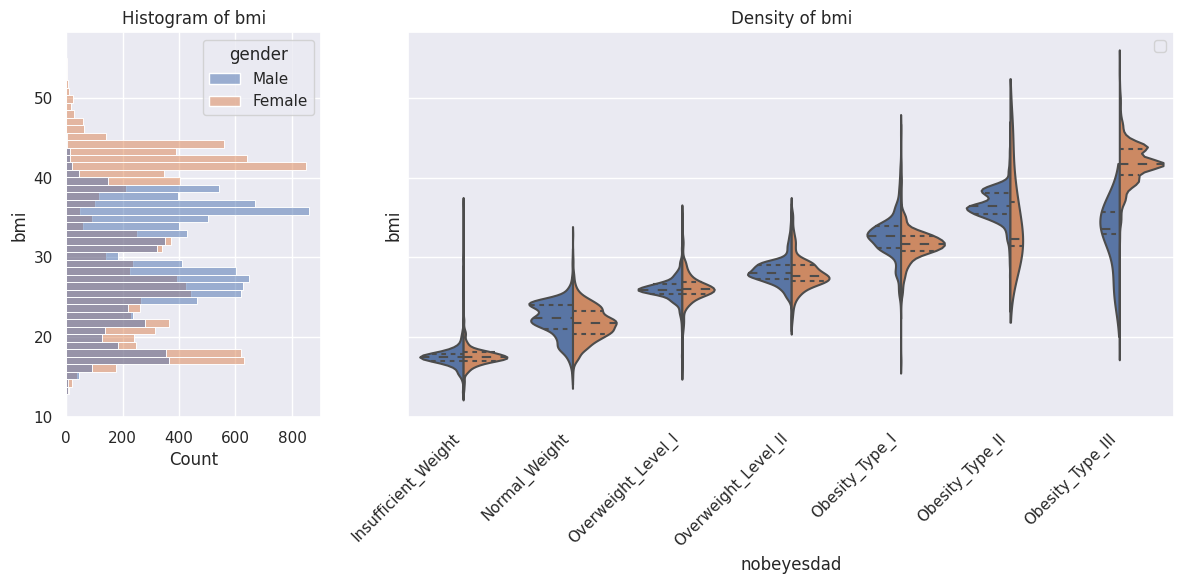

In [18]:
col = 'bmi'
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, width_ratios=[1, 3])
sns.histplot(df0, y=col, ax=axs[0], hue='gender')
sns.violinplot(df0, y=col, x='nobeyesdad', hue='gender', split=True, 
               inner='quart', density_norm='count', ax=axs[1])
axs[0].set_title('Histogram of ' + col)
axs[1].set_title('Density of ' + col)
plt.xticks(rotation=45, ha='right')
axs[1].legend([])
plt.tight_layout()
plt.show()

- `bmi` shows strong correlation with obesity status, as expected.
- Female tends to have higher `bmi` when in `Obesity_Type_III` status.

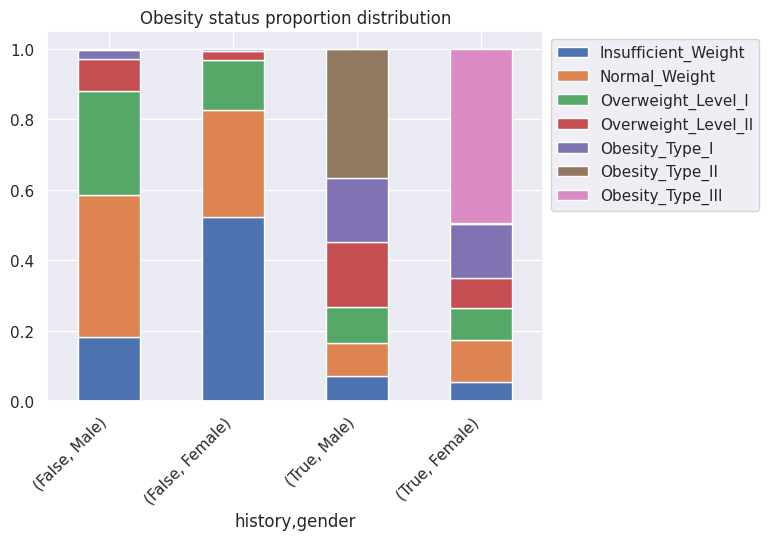

In [19]:
col = 'history'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- With family obesity history, people is more likely to have severe obesity
    - Male tends to have type II obesity
    - Female tends to have type III obesity 

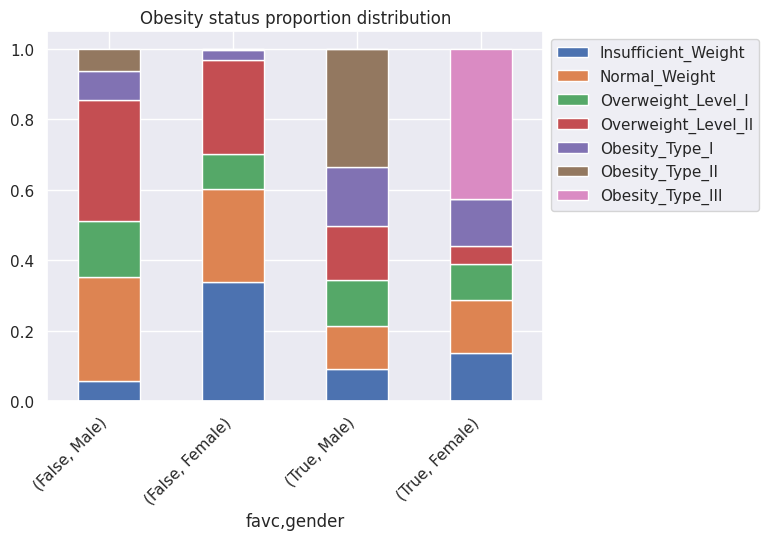

In [20]:
col = 'favc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

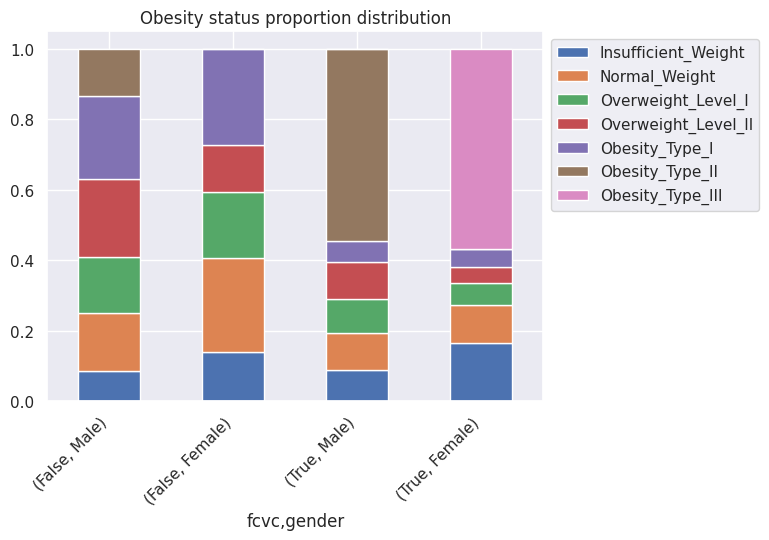

In [21]:
col = 'fcvc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Eat more vegetable has higher obesity risk???
    - Maybe they eat salad with lots of high calorie source?
    - Maybe they eat more food overall?

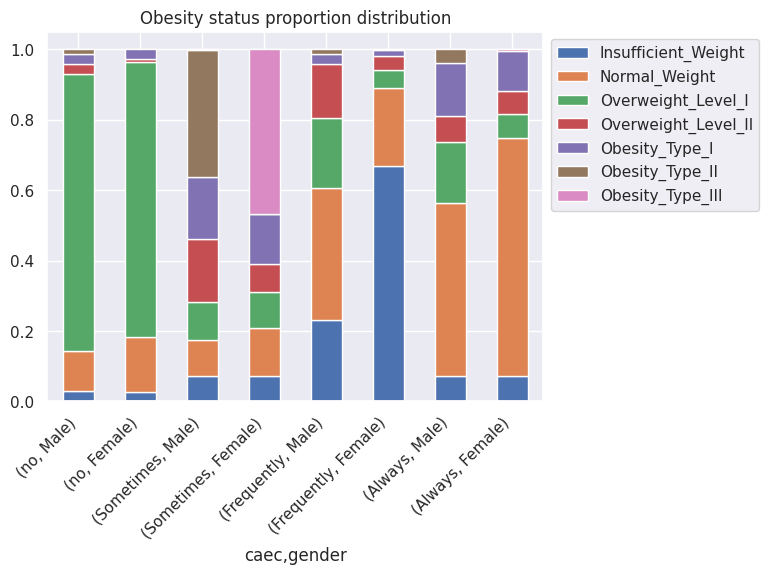

In [22]:
col = 'caec'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Sub meal frequency does NOT show linear correlation to obesity risk
    - `Sometimes` sub meal has very high obesity risk, maybe people sometimes take sub meal is for satisfaction purpose.
    - We need to change the order of `caec` categories inorder to have linear correlation with obesity risk.

In [23]:
# Change the order of 'caec'
df0['caec'] = df0['caec'].cat.reorder_categories(['Frequently', 'Always', 'no', 'Sometimes'], True)
df0['caec_lvl'] = df0['caec'].cat.codes

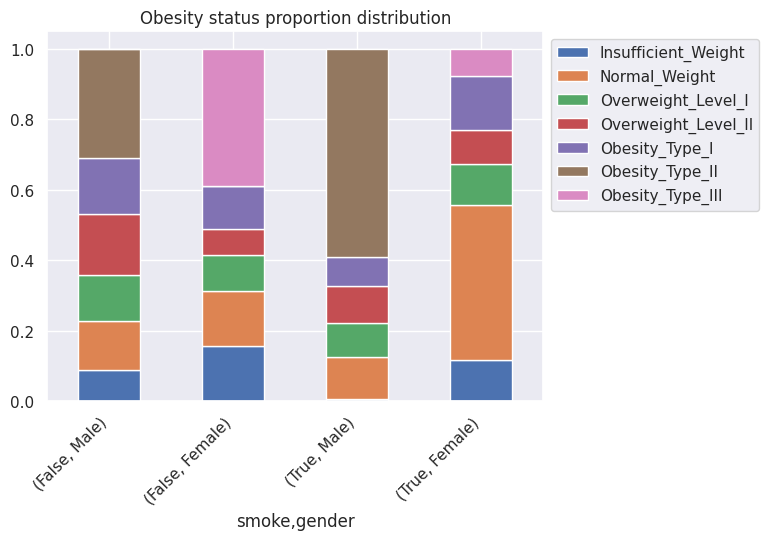

In [24]:
col = 'smoke'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

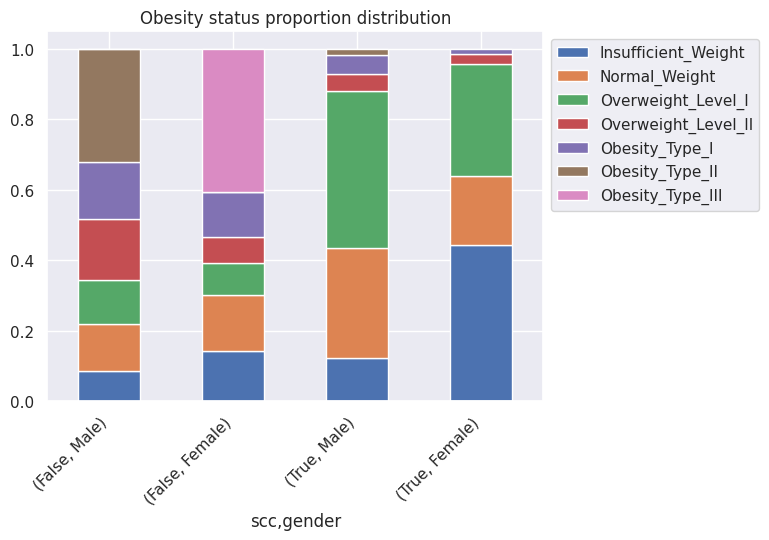

In [25]:
col = 'scc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- Clearly people monitor food calorie is healthier with much less obesity risk.

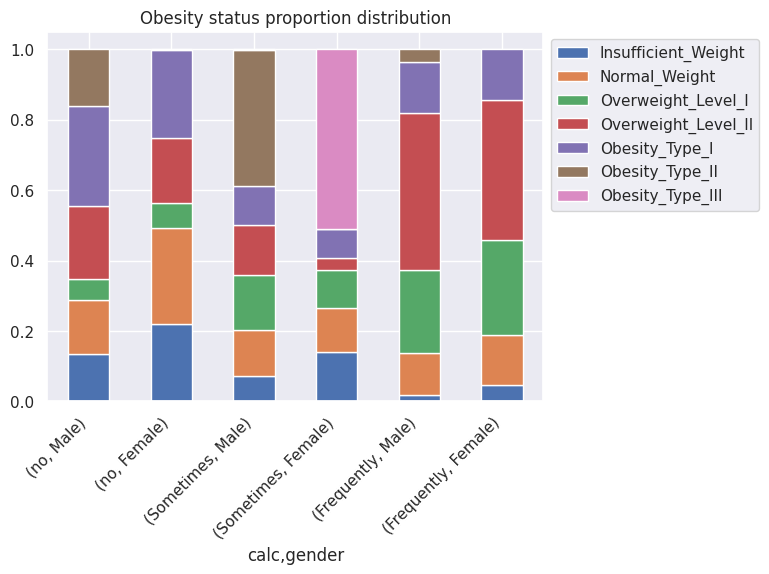

In [26]:
col = 'calc'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

- There is trend, but NOT linear correlation.
    - People who drink `Sometimes` has very high obesity risk, maybe they drink for satisfaction and consumes lots of high calorie side foods together.
    - We shall change category order also.

In [27]:
# Change the order of 'calc'
df0['calc'] = df0['calc'].cat.reorder_categories(['Frequently', 'no', 'Sometimes'], True)
df0['calc_lvl'] = df0['calc'].cat.codes

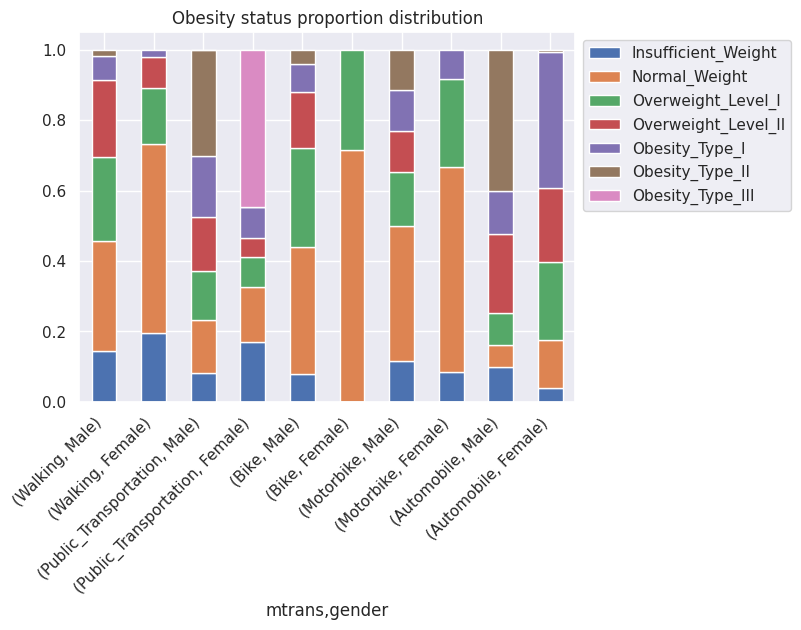

In [28]:
col = 'mtrans'
df0.groupby(['gender', col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col, 'gender']).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.title('Obesity status proportion distribution')
plt.show()

In [29]:
# Change the order of 'mtrans'
df0['mtrans'] = df0['mtrans'].cat.\
    reorder_categories(['Walking', 'Bike', 'Motorbike', 'Automobile', 'Public_Transportation'], True)
df0['mtrans_lvl'] = df0['mtrans'].cat.codes

Now let's check the correlation matrix.

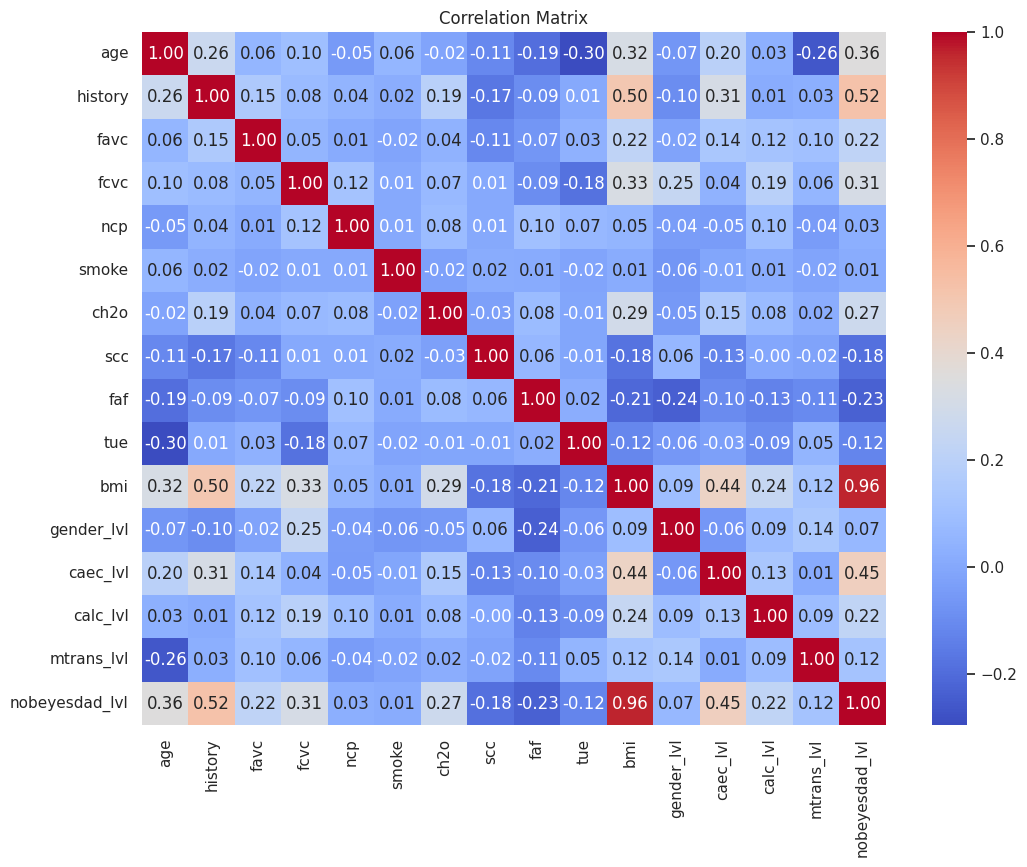

In [30]:
plt.figure(figsize=(12, 9))
sns.heatmap(df0.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Summary of EDA**  
- `bmi` has the strongest correlation to `NObeyesdad`, followed by `history`, `caec`, `age`, etc.
- Male and female with type II and type III obesity have very different features.
- People with healthier life style (e.g. walking, monitor food calorie, less satisfaction alchohol and sub meal consumption, etc.) has less obesity risk.

Before constructing prediction models, let's see if we can find clusters from the independent features which can enhance the power of obesity level prediction.

In [31]:
# prepare data for KMeans model fitting
drop_cols = [col for col in df0.columns if df0[col].dtype == 'category']
drop_cols.append('nobeyesdad_lvl')
X_df = df0.drop(columns=drop_cols).copy()
normalizer = Normalizer()
X = normalizer.fit_transform(X_df)

In [32]:
# perform KMeans fitting, using inertia and silhouette scores to find optimized K value
num_clusters = range(2, 11)
inertial_score = []
sil_score = []
for n in num_clusters:
    km = KMeans(n_clusters=n, random_state=0)
    km.fit(X)
    inertial_score.append(km.inertia_)
    sil_score.append(metrics.silhouette_score(X, km.labels_))

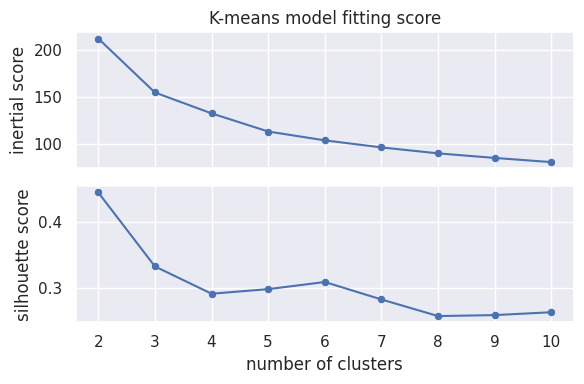

In [33]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,4))
sns.scatterplot(x=num_clusters, y=inertial_score, ax=axs[0])
sns.lineplot(x=num_clusters, y=inertial_score, ax=axs[0])
sns.scatterplot(x=num_clusters, y=sil_score, ax=axs[1])
sns.lineplot(x=num_clusters, y=sil_score, ax=axs[1])
axs[0].set_title('K-means model fitting score')
axs[0].set_ylabel('inertial score')
axs[1].set_ylabel('silhouette score')
axs[1].set_xlabel('number of clusters')
plt.tight_layout()

6 may be the optimized cluster number.

In [34]:
km = KMeans(6, random_state=0)
km.fit(X)

KMeans(n_clusters=6, random_state=0)

In [35]:
df0['cluster'] = km.labels_

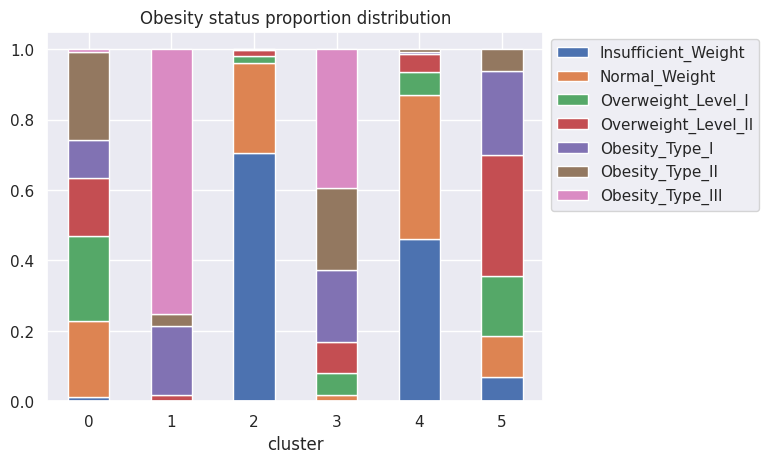

In [36]:
col = 'cluster'
df0.groupby([col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col]).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, ha='center')
plt.title('Obesity status proportion distribution')
plt.show()

We can see some power to predict obesity level.  
Let's reassign the category code accordingly.

In [37]:
df_cluster = df0.groupby('cluster')['nobeyesdad_lvl'].mean().sort_values().reset_index()
map_dict = {}
for i in range(6):
    map_dict[df_cluster.loc[i, 'cluster']] = i
df0['cluster'] = df0['cluster'].map(map_dict)

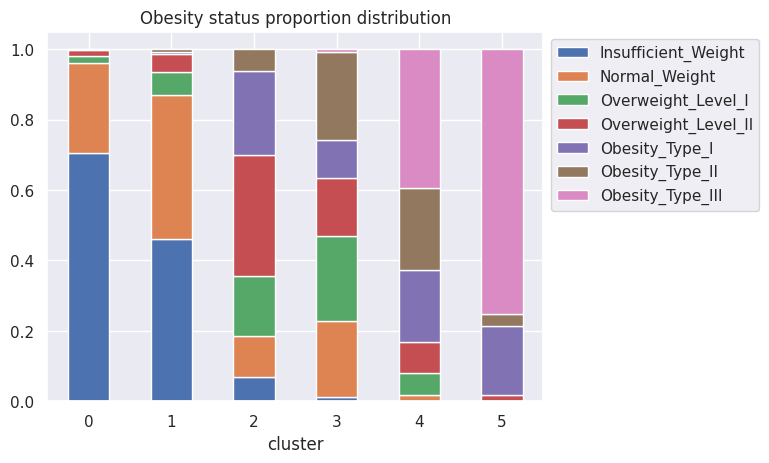

In [38]:
col = 'cluster'
df0.groupby([col])['nobeyesdad'].value_counts(normalize=True).\
    reset_index().set_index([col]).pivot(columns='nobeyesdad', values='proportion').\
    plot(kind='bar', stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, ha='center')
plt.title('Obesity status proportion distribution')
plt.show()

## Future Plan

1. Optimizing scaler for KNN model --> [Link](https://www.kaggle.com/code/ustcer1984/obesity-prediction-knn-model-scaler-tuning-s4e2)
2. Ethics concern on model and metric score selection --> [Link](https://www.kaggle.com/ustcer1984/obesity-ethics-concern-on-model-selection)